# **Imports**

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [47]:
pd.set_option('display.max_rows', None)#To display all rows

# **Data Preprocessing**

*Loading the datasset "recours"*

In [48]:
df = pd.read_csv('C:\\Users\\ahmed\\Downloads\\Docs Hackathon - Fraude\\Docs Hackathon - Fraude\\E-recours 2024\\data-1715774388994 - Recours.csv')


C:\Users\ahmed\AppData\Local\Temp\ipykernel_2436\4241597952.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\ahmed\\Downloads\\Docs Hackathon - Fraude\\Docs Hackathon - Fraude\\E-recours 2024\\data-1715774388994 - Recours.csv')


*Exploring the data*

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38942 entries, 0 to 38941
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Id                                   38942 non-null  object 
 1   ApplicantReference                   38942 non-null  object 
 2   DefendantReference                   38942 non-null  object 
 3   SinistreDate                         38942 non-null  object 
 4   Status                               38942 non-null  object 
 5   Reference                            38942 non-null  object 
 6   ApplicantSinistreNumber              38942 non-null  object 
 7   DefendantSinistreNumber              28168 non-null  object 
 8   SinistrePlace                        33848 non-null  object 
 9   ApplicantCompanyContractNumber       38942 non-null  object 
 10  DefendantCompanyContractNumber       32933 non-null  object 
 11  PlaintiffCompanyInsuredLiabi

In [50]:
df.describe()

,PlaintiffCompanyInsuredLiability,DefendantCompanyInsuredLiability,RecoveredAmount,Index,CreatedById,ModifiedById,EstimedAmount,HIDA_Index,DelaiVariable,ProposedAmount,ArbitratedAmount,AmicableAmount,ExpertArbitreAmount
count,38942.000000,38942.000000,38942.0,38942.000000,0.0,0.0,14721.000000,38942.000000,38942.0,2.210000e+02,0.0,3.000000,1.000
mean,2.064609,95.533357,0.0,39.572210,NaN,NaN,35.358400,0.234554,0.0,2.506007e+05,NaN,12694.298667,11334.338
std,10.687273,18.506845,0.0,37.006945,NaN,NaN,1267.126776,0.473037,0.0,1.019619e+06,NaN,7079.856529,NaN
min,0.000000,-100.000000,0.0,1.000000,NaN,NaN,0.000000,0.000000,0.0,0.000000e+00,NaN,7378.740000,11334.338
25%,0.000000,100.000000,0.0,11.000000,NaN,NaN,0.000000,0.000000,0.0,0.000000e+00,NaN,8675.939000,11334.338
50%,0.000000,100.000000,0.0,27.000000,NaN,NaN,0.000000,0.000000,0.0,8.308000e+02,NaN,9973.138000,11334.338
75%,0.000000,100.000000,0.0,58.000000,NaN,NaN,0.000000,0.000000,0.0,5.555003e+03,NaN,15352.078000,11334.338
max,100.000000,100.000000,0.0,213.000000,NaN,NaN,152000.000000,4.000000,0.0,1.048553e+07,NaN,20731.018000,11334.338


In [51]:
df.shape

(38942, 43)

*Filling missing values*

In [52]:
df = df.fillna(0)

# Feature Extraction

In [53]:
df = df.drop(columns=['DelaiVariable','TypePersonne','CreatedById','SinistrePlace','ApplicantCompanyInsuredRegistration','DefendantCompanyInsuredRegistration','RequestedAmount','ExtraInfoId','DDelaiFolderId','ModifiedBy','ModifiedById','Id','ExpertArbitreAmount','ArbitratedAmount','AmicableAmount','ApplicantCompanyId', 'DefendantCompanyId','ApplicantCompanyContractNumber', 'DefendantCompanyContractNumber', 'RequestedAmount' ,'RecoveredAmount'])

*What do we consider as  **Fradulant** data and **Proper** data*

In [54]:
accepted_statuses = ['Accepté', 'Complet', 'Dossier réclamé en instance d’acceptation', 'Vrai doublon', 'Annulé',
                     'Traité hors plateforme', 'En instance de compensation', 'Dossier en instance d’acceptation',
                     'Contestation acceptée', 'Recours Accepté', 'Requalifié', 'Soumis pour acceptation au recours',
                     'Doublon', 'Sans Suite', 'Règlement Contesté', 'Aribitrage Accpeté', 'Demande recours retirée',
                     'Contestation recours acceptée', 'Rejet contesté', 'En attente de confirmation du recours',
                     "En attente d'arbitrage(Expert Arbitre)", "En attente d'arbitrage(Montant Proposé)",'Contestation de recours Accepté', 'Recours contesté']

fraudulent_statuses = ['InComplet', 'Contestation recours refusée', 'Contestation Refusée', 'Rejeté', 'Débouté',
                        'Contestation de recours refusée', 'Arbitrage refusé']

# Create a new column for simplified status
df['SimplifiedStatus'] = df['Status'].apply(lambda x: 0 if x in accepted_statuses else 1 if x in fraudulent_statuses else 2)

In [55]:
# Convert categorical variables to numerical
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str)
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [56]:
# Separate features and labels
features = df.drop(columns=['SimplifiedStatus'])
labels = df['SimplifiedStatus']

**Data Normalization**

In [57]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## **1st.** Random Forest Classifer 

In [127]:
clf = RandomForestClassifier(n_estimators=5, random_state=0)
clf.fit(features_scaled, labels)

RandomForestClassifier(n_estimators=5, random_state=0)

## **2nd.** Apply PCA

In [128]:
pca = IncrementalPCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

## **3rd.** K-means (Just for visualizing data)

In [129]:
kmeans = MiniBatchKMeans(n_clusters=2)
kmeans.fit(principalDf)

# Add labels to the dataframe
principalDf['Cluster'] = kmeans.labels_
principalDf['SimplifiedStatus'] = labels

**Data Visualization**

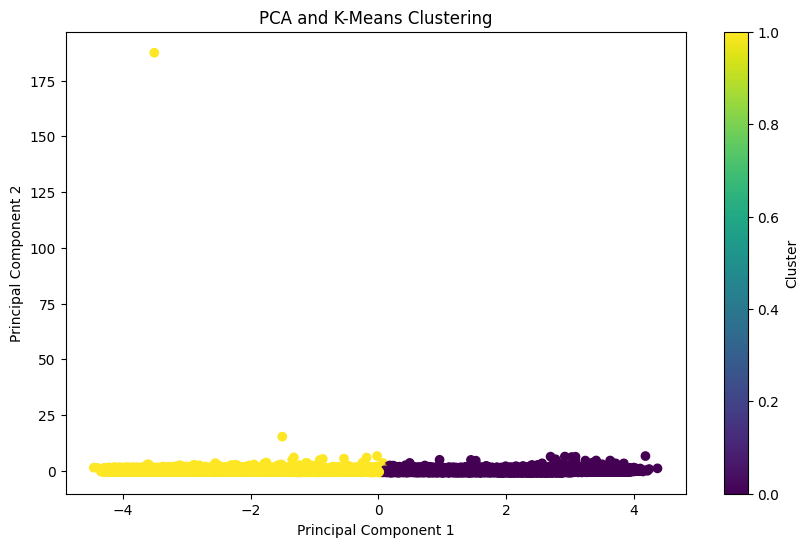

In [130]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA and K-Means Clustering')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.show()

In [131]:
# Get the predicted probabilities of the positive class (fraudulent)
pred_probs = clf.predict_proba(features_scaled)[:, 1]

*Adjust the threshold for classification **default** to **fraudulent** unless proven otherwise*

In [132]:
threshold = 0.48  #lower threshold to increase the bias towards fraud
pred = (pred_probs >= threshold).astype(int)

*Making it better to look at and understand*

In [133]:
df['Anomaly'] = pred

*Visualisation of our DataFrame*

In [134]:
print(df.head(20))

    ApplicantReference  DefendantReference  SinistreDate  Status  Reference  \
0                    1                  11           574       0       5164   
1                    3                  12           202       0       7833   
2                    0                   3          1785       4        377   
3                   10                   6           202      13      25139   
4                   12                   9            17       0      34814   
5                    0                   8           997      30       1552   
6                   12                   0           208       0      31461   
7                   12                   0            17       0      31422   
8                   12                   7           485       0      33582   
9                   12                  11            17       0      36047   
10                   6                  10           252       0      12737   
11                   4                   6          

*Proportion of accepted and fraudulent statuses in each anomaly group*

In [135]:
anomaly_status = df.groupby('Anomaly')['SimplifiedStatus'].value_counts(normalize=True).unstack()
print(anomaly_status)

SimplifiedStatus         0         1
Anomaly                             
0                 0.999835  0.000165
1                 0.000803  0.999197


# Accuracy

In [136]:
# Splitting the data into a training set and a test set
features_train, features_test, labels_train, labels_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Training the model on the training set
clf.fit(features_train, labels_train)

# Test the model on the test set
labels_pred = clf.predict(features_test)

accuracy = (labels_pred == labels_test).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.9975606624727179


## F1 Score

In [137]:
f1 = f1_score(labels_test, labels_pred, average='binary')  
print(f'F1 Score: {f1}')

F1 Score: 0.9799366420274551


AUC: 0.9986964399775787


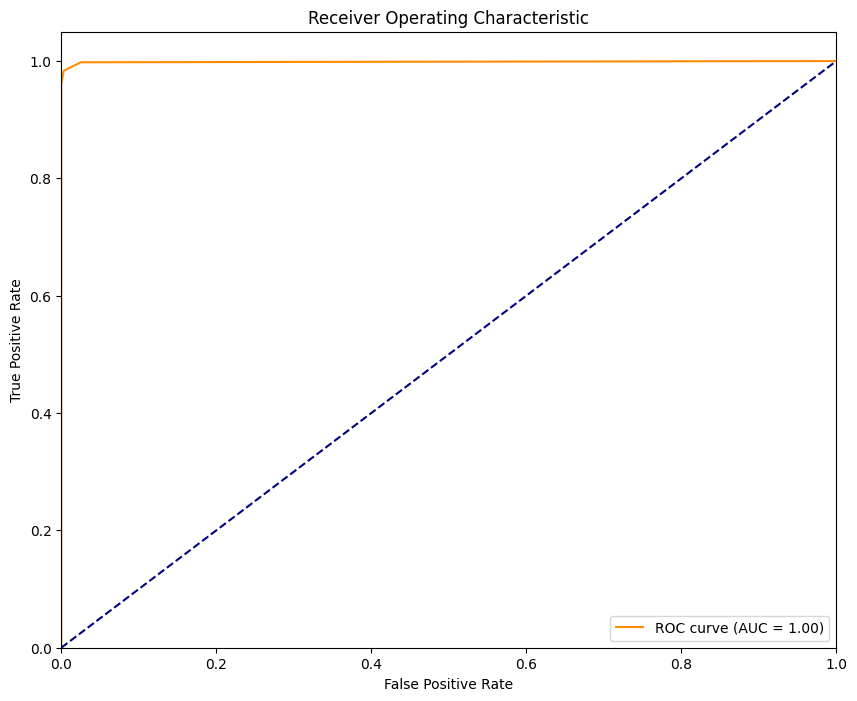

In [139]:

# Calculate the probabilities of the positive class
probs = clf.predict_proba(features_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, probs)

# Calculate the AUC
auc = roc_auc_score(labels_test, probs)
print(f'AUC: {auc}')

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# THE HEATMAP 🪨

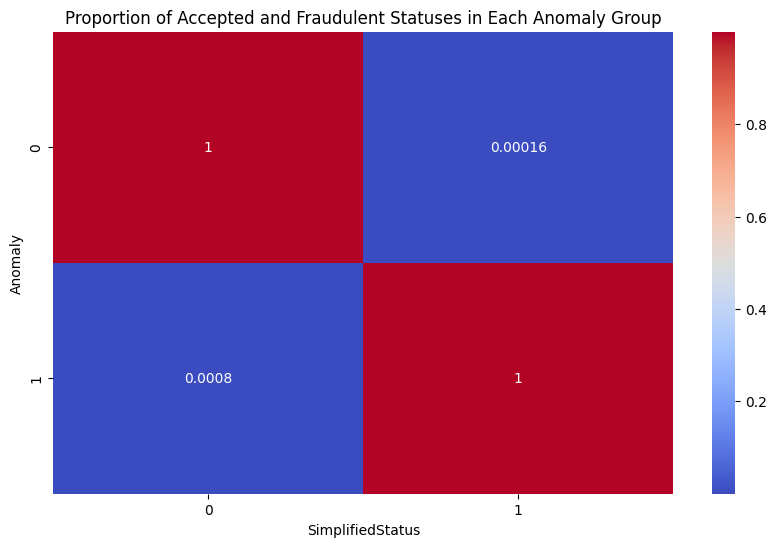

In [138]:
plt.figure(figsize=(10, 6))
sns.heatmap(anomaly_status, annot=True, cmap='coolwarm')
plt.title('Proportion of Accepted and Fraudulent Statuses in Each Anomaly Group')
plt.xlabel('SimplifiedStatus')
plt.ylabel('Anomaly')
plt.show()